## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# import the dataset and print out few lines to check the data
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
users = len(df['user_id'].unique())
users

290584

d. The proportion of users converted.

In [5]:
len(df.query('converted == 1')['user_id'].unique())/users

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query('(landing_page != "new_page" and group == "treatment") or (landing_page == "new_page" and group != "treatment")')['user_id'].count()

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.drop(df[((df.landing_page == 'new_page') &( df.group != 'treatment'))].index)

In [9]:
df2.drop(df2[((df2.landing_page != 'new_page') &( df2.group == 'treatment'))].index,inplace = True)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
len(df2['user_id'].unique())


290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2['user_id'].duplicated() == True]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop(index = 2893,inplace = True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query('converted == 1 and group == "control"')['user_id'].count()/df2.query('group == "control"')['user_id'].count()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query('converted == 1 and group == "treatment"')['user_id'].count()/df2.query('group == "treatment"')['user_id'].count()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
df2.query('landing_page == "new_page"')['user_id'].count()/df2.shape[0]

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**There isn't sufficient evidence to conclude that the new treatment page leads to more conversions as probability for converting is approximately 12% of both groups.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

> Null Hypothesis : p_old >= p_new || 
> Alternate Hypothesis : p_old < p_new.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
# NULL Hypothesis
df2.query('landing_page == "new_page" and converted == 1')['user_id'].count() == df2.query('landing_page == "old_page" and converted == 1')['user_id'].count()

False

In [20]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2.converted.mean()
p_old


0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new = df2.query('group == "treatment"')['user_id'].count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = df2.query('group == "control"')['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([0,1],n_new,p = [p_new,1-p_new]).mean()

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted =np.random.choice([0,1],n_old,p = [p_old,1-p_old]).mean()

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
new_page_converted - old_page_converted

0.0017779981968856218

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
p_diffs = []
for _ in range(10000):
    new_page_con = np.random.choice([0, 1], size = n_new, p = [p_new, 1 - p_new],replace = True).mean()
    old_page_con = np.random.choice([0, 1], size = n_old, p = [p_old, 1 - p_old],replace = True).mean()
    p_diffs.append(new_page_con - old_page_con)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

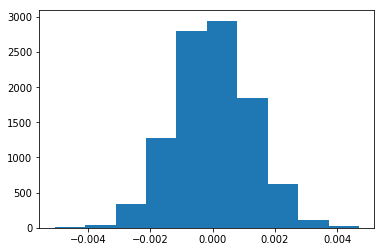

In [28]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
# convert array to numpy array
p_diffs = np.array(p_diffs)
p_diffs


array([ -7.20535640e-04,   8.83096522e-04,   2.56854305e-04, ...,
        -6.64676278e-05,   8.34930472e-04,  -1.14045742e-03])

In [30]:
# Find the difference in mean of two groups
p_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
p_diff

-0.0015782389853555567

In [31]:
# finding the p value for hypothesis testing
(p_diffs > p_diff).mean()

0.90429999999999999

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> **We computed the p value of our model, which is the probability of observing your statistic if the null hypothesis is true.**

> It is also considered as the probability that random chance generated your data or something else that is equal or rarer.

> Given our null hypothesis being "p_old >= p_new", we are computing how much of our data generated consistent with hypothesis and we fail to reject the null hypothesis. If p < 0.05, then we will reject null hypothesis and choose our alternate hypothesis with p_old < p_new. 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [33]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

In [34]:
from scipy.stats import norm

norm.cdf(z_score)

0.90505831275902449

In [35]:
norm.ppf(1-(0.05/2))

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Our computed z-value is 1.31 which does not exceed the critical value at 95% confidence interval, thus we fail to reject the null hypothesis. Morever our p-value of 0.90 is consistent with our findings and inference from z-value.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?



**Each row is either a conversion or no conversion, probability between 0 and 1, this is binary problem for which we can use Logistic regression to compute the model metrics.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
df2[['control','ab_page']] = pd.get_dummies(df['group'])
df2[['new_page','old_page']] = pd.get_dummies(df['landing_page'])
df2['intercept'] = 1

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [37]:
mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
res = mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-04-20 18:06 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Our p-value 0.19 is significantly different from our previous p value 0.9, this is due to changes in our hypothesis**

> Earlier: 
NULL : p_old == p_new || Alternate : p_old != p_new

> Now:
NULL : p_old >= p_new || Alternate : p_old < p_new

Change in probability is partially because now we dont have only two outcomes but more.


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Yes, It is a good idea to consider other factors to add into our regression model to make it more efficient and accurate in prediciting our outcomes which in this case, converted or not converted**

> Disadvantages : Correlated errors could make predictions less accurate.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  
> According to p-values , our statistical output there seems to be no evident of this independent variable being statistically relevant in predictions for our model.

In [39]:
df_country = pd.read_csv('countries.csv')
df_country.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [40]:
df2 = df2.merge(df_country,how = 'inner', on = 'user_id')
df2.head(1)

,user_id,timestamp,group,landing_page,converted,control,ab_page,new_page,old_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,1,1,US


In [41]:
df2[['CA','UK','US']] = pd.get_dummies(df2['country'])

In [42]:
mod = sm.Logit(df2['converted'],df2[['intercept','CA','UK']])
res = mod.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-04-20 18:06 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
mod = sm.Logit(df2['converted'],df2[['intercept','ab_page','CA','UK']])
res = mod.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-04-20 18:06 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

<a id='conclusions'></a>
## Results

1. According to statistical measures, there seems of be no evidence of these independent variables being statistically relevant in predictions , and we fail to reject the null hypothesis .

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])